In [39]:
#https://github.com/bradleypallen/keras-dogs-vs-cats/blob/master/keras-dogs-vs-cats-vgg16-transfer-fine-tuning.ipynb
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout
from keras.callbacks import Callback, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.applications.vgg16 import preprocess_input

In [40]:
# IMG_WIDTH, IMG_HEIGHT = 150, 150
IMG_WIDTH, IMG_HEIGHT = 64, 64 #tuberculosis
IMG_CHANNEL = 1
IMG_COUNT = 8262


BATCH_SIZE = 2
NUM_CLASSES = 2 
NUM_EPOCHS = 50

TRAIN_IMAGE_FILE_PATH = './dataset/train_image_64x64_gray_447648.bin'
TRAIN_LABEL_FILE_PATH = './dataset/train_label_64x64_gray_447648.bin'
TEST_IMAGE_FILE_PATH = './dataset/test_image_64x64_gray_15873.bin'
TEST_LABEL_FILE_PATH = './dataset/test_label_64x64_gray_15873.bin'

TRAIN_DATA_COUNT = 447648
TEST_DATA_COUNT = 15873
VALIDATION_DATA_COUNT = 89530
TRAIN_SIZE = TRAIN_DATA_COUNT - VALIDATION_DATA_COUNT

MODEL_WEIGHTS_FILE = 'vgg16-bin-xfer-tuned-weights.h5'

In [41]:
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

In [42]:
for layer in model_vgg16_conv.layers[:-4]:
    layer.trainable = False

In [43]:
input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = model_vgg16_conv(input)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input=input, output=x)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [44]:
model.compile(loss='binary_crossentropy',
        optimizer=SGD(lr=1e-4, momentum=0.9),
        metrics=['accuracy'])

In [45]:
def load_image(filename, count, row, col, channel):
    print('Loading data from', filename)

    print('file size : ', os.path.getsize(filename))
    print('calc size : ', count * row * col * channel)
    
    s = []
    A = np.fromfile(filename, dtype='int8', sep="")
    for i in range(len(A)//4096):
        vec = A[i*4096:4096*(i+1)]
        img = vec.reshape([64, 64, 1])
        s.append(img)
    data = np.asarray(s)
    print(data.shape)

    return data

def load_label(filename, count, classes):
    print('Loading labels from ', filename)
    
    print('file size : ', os.path.getsize(filename))
    print('calc size : ', count)
    
    fp = open(filename, 'r')
    buf = fp.read(count)
        
    data_bin = []
    for i in buf:
        data_bin.append(i)
    data = np.asarray(data_bin, dtype=np.uint8, order='C')
    

    print('loaded shape : ', data.shape)
    
    label_hist = np.histogram(data, bins=range(NUM_CLASSES+1))
    print(label_hist)
    
    data = np_utils.to_categorical(data, classes)

    return data_bin

In [46]:
train_image = load_image(TRAIN_IMAGE_FILE_PATH, TRAIN_DATA_COUNT, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)
test_image = load_image(TEST_IMAGE_FILE_PATH, TEST_DATA_COUNT, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)

train_label = load_label(TRAIN_LABEL_FILE_PATH, TRAIN_DATA_COUNT, NUM_CLASSES)
test_label = load_label(TEST_LABEL_FILE_PATH, TEST_DATA_COUNT, NUM_CLASSES)

Loading data from ./dataset/train_image_64x64_gray_447648.bin
file size :  1833566208
calc size :  1833566208
(447648, 64, 64, 1)
Loading data from ./dataset/test_image_64x64_gray_15873.bin
file size :  65015808
calc size :  65015808
(15873, 64, 64, 1)
Loading labels from  ./dataset/train_label_64x64_gray_447648.bin
file size :  447648
calc size :  447648
loaded shape :  (447648,)
(array([354528,  93120], dtype=int64), array([0, 1, 2]))
Loading labels from  ./dataset/test_label_64x64_gray_15873.bin
file size :  15873
calc size :  15873
loaded shape :  (15873,)
(array([15520,   353], dtype=int64), array([0, 1, 2]))


In [47]:
q=0
train_image_dataset=[]
train_img_array_path = cv2.imread("./dataset/images2.jpg")
train_img_array = np.zeros_like(train_img_array_path)

for i in train_image[:]:
    patch_image = i.reshape((IMG_WIDTH,IMG_HEIGHT))
    patch_image = patch_image.astype(np.uint8)

    train_img_array[:,:,0] = patch_image
    train_img_array[:,:,1] = patch_image
    train_img_array[:,:,2] = patch_image
        
    train_image_dataset.append(train_img_array)

    q+=1
    train_img_array = np.zeros_like(train_img_array_path)
train_image_dataset = np.array(train_image_dataset)
print(train_image_dataset.shape)

(447648, 64, 64, 3)


In [53]:
q=0
test_image_dataset=[]
test_img_array_path = cv2.imread("./dataset/images2.jpg")
test_img_array = np.zeros_like(test_img_array_path)

for i in test_image[:]:
    patch_image = i.reshape((IMG_WIDTH,IMG_HEIGHT))
    patch_image = patch_image.astype(np.uint8)

    test_img_array[:,:,0] = patch_image
    test_img_array[:,:,1] = patch_image
    test_img_array[:,:,2] = patch_image
        
    test_image_dataset.append(test_img_array)
#     cv2.imwrite('./testdataset/test'+str(q)+'.png', test_img_array)
    q+=1
    test_img_array = np.zeros_like(test_img_array_path)

test_image_dataset = np.asarray(test_image_dataset)
print(test_image_dataset.shape)

(15873, 64, 64, 3)


In [49]:
model.fit(train_image_dataset[:TRAIN_SIZE], 
          train_label[:TRAIN_SIZE], 
          batch_size = BATCH_SIZE, 
          epochs = NUM_EPOCHS,
          verbose = 1, 
          validation_data = (train_image_dataset[TRAIN_SIZE:], train_label[TRAIN_SIZE:]))

C:\Program Files\Anaconda3\lib\site-packages\keras-2.0.4-py3.5.egg\keras\backend\tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 358118 samples, validate on 89530 samples
Epoch 1/50
358118/358118 [==============================] - 279s - loss: 0.1673 - acc: 0.9317 - val_loss: 0.1364 - val_acc: 0.9412
Epoch 2/50
358118/358118 [==============================] - 278s - loss: 0.1429 - acc: 0.9405 - val_loss: 0.1360 - val_acc: 0.9423
Epoch 3/50
358118/358118 [==============================] - 278s - loss: 0.1377 - acc: 0.9420 - val_loss: 0.1296 - val_acc: 0.9439
Epoch 4/50
358118/358118 [==============================] - 278s - loss: 0.1343 - acc: 0.9433 - val_loss: 0.1293 - val_acc: 0.9448
Epoch 5/50
358118/358118 [==============================] - 278s - loss: 0.1312 - acc: 0.9444 - val_loss: 0.1262 - val_acc: 0.9456
Epoch 6/50
358118/358118 [==============================] - 278s - loss: 0.1294 - acc: 0.9453 - val_loss: 0.1298 - val_acc: 0.9427
Epoch 7/50
358118/358118 [==============================] - 279s - loss: 0.1276 - acc: 0.9460 - val_loss: 0.1231 - val_acc: 0.9467
Epoch 8/50
358118/358118 [======

In [54]:
# 딥러닝 모델 테스트를 수행합니다.
test_labels = [int(v) for v in test_label]

score = model.evaluate(test_image_dataset, test_labels, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

classes = model.predict(test_image_dataset, batch_size=1)

np.savetxt('./tuberculosis_binaryfile_result4.txt', classes, fmt='%d')


# p=[]
# for i in classes:
#     if(i[0]>i[1]):
#         p.append(0)
#     else:
#         p.append(1)
# np.savetxt('./tuberculosis_binaryfile_result2.txt', p, fmt='%d')

15872/15873 [============================>.] - ETA: 0sTest score: 0.070805704078
Test accuracy: 0.981162981163


In [56]:
TP_num = 0
FP_num = 0
TN_num = 0
FN_num = 0

TP_list = []
FP_list = []
TN_list = []
FN_list = []
# test_labels = np.array([0] * 372480 + [1] * 8472)

classes = [int(v) for v in classes]
for im in zip(test_image_dataset, classes, test_labels):
    if im[1] != im[2] and im[1] == 1:
        FP_list.append(im)
        FP_num += 1
    if im[1] != im[2] and im[1] == 0:
        FN_list.append(im)
        FN_num += 1
    if im[1] == im[2] and im[1] == 1:
        TP_list.append(im)
        TP_num += 1
    if im[1] == im[2] and im[1] == 0:
        TN_list.append(im)
        TN_num += 1

print ("TP = ", TP_num,  " FP = ", FP_num, " TN = ", TN_num, " FN = ", FN_num)
print("민감도 = " + str(TP_num/353) + " / 특이도 = ", TN_num/15520)

TP =  8  FP =  2  TN =  15518  FN =  345
민감도 = 0.0226628895184136 / 특이도 =  0.9998711340206186


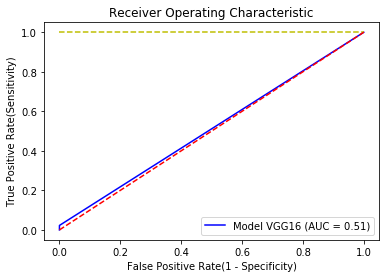

In [52]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

false_positive_rate_F, true_positive_rate_F, thresholds_F = roc_curve(test_labels, classes)
roc_auc_F = auc(false_positive_rate_F, true_positive_rate_F)

# print(roc_auc_F)

plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate_F, true_positive_rate_F, 'b', label='Model VGG16 (AUC = %0.2f)'% roc_auc_F)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')
plt.legend(loc='lower right')
plt.show()